# Functions

In [34]:
#functions

def loadsettings():
    global settings
    global pixelsPerMetric
    global mincanny
    global maxcanny
    global safetyzonex
    global safetyzoney
    global blur
    settings = np.asarray(pd.read_excel('settings.xlsx'))
    pixelsPerMetric=float(settings[0,1])
    mincanny=int(settings[1,1])
    maxcanny=int(settings[2,1])
    safetyzonex=int(settings[3,1])
    safetyzoney=int(settings[4,1])
    blur=int(settings[5,1])
    return()

def savesettings(settings):
    settings = pd.DataFrame (settings)
    settings.to_excel('settings.xlsx', index=False)
    
def nothing(x):
    pass
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)


def gettrackbars():
    
    global mincanny
    global maxcanny
    global safetyzonex
    global safetyzoney
    global blur
    mincanny=cv2.getTrackbarPos("min","contour")
    maxcanny=cv2.getTrackbarPos("max","contour")
    safetyzonex=cv2.getTrackbarPos("borderx","contour")
    safetyzoney=cv2.getTrackbarPos("bordery","contour")
    blur=cv2.getTrackbarPos("Blur","contour")
    count = blur % 2 
    if (count == 0):
        blur += 1
    cv2.setTrackbarPos("Blur","contour",blur)

def createwindow():
    cv2.namedWindow('contour')
    cv2.createTrackbar("min","contour",0,400,nothing)
    cv2.createTrackbar("max","contour",0,400,nothing)
    cv2.createTrackbar("borderx","contour",0,200,nothing)
    cv2.createTrackbar("bordery","contour",0,200,nothing)
    cv2.createTrackbar("Blur", "contour", 1, 21, nothing)
    cv2.setTrackbarPos("min","contour",maxcanny)
    cv2.setTrackbarPos("max","contour",mincanny)
    cv2.setTrackbarPos("borderx","contour",safetyzonex)
    cv2.setTrackbarPos("bordery","contour",safetyzoney)
    cv2.setTrackbarPos("Blur","contour",blur)
    
def crop_coord(img,cnt):
    # find the exact rectangle enclosing the text area
    # rect is a tuple consisting of 3 elements: the first element is the center
    # of the rectangle, the second element is the width, height, and the
    # third element is the detected rotation angle.
    # Example output: ((227.5, 187.50003051757812),
    # (94.57575225830078, 417.98736572265625), -36.982906341552734)
    rect = cv2.minAreaRect(cnt)
#    print("rect: {}".format(rect))

    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # print("bounding box: {}".format(box))
#    cv2.drawContours(img, [box], 0, (0, 0, 255), 2)

    # img_crop will the cropped rectangle, img_rot is the rotated image
    img_crop, img_rot = crop_rect(img, rect)
    (h, w) = img_crop.shape[:2]
    #make sure all pictures are vertical
    if(h<w):
        img_crop = cv2.rotate(img_crop, cv2.ROTATE_90_CLOCKWISE)

  #  cv2.waitKey(0)
    return img_crop


def crop_rect(img, rect):
    # get the parameter of the small rectangle
    center, size, angle = rect[0], rect[1], rect[2]
    center, size = tuple(map(int, center)), tuple(map(int, size))

    # get row and col num in img
    height, width = img.shape[0], img.shape[1]

    # calculate the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1)
    # rotate the original image
    img_rot = cv2.warpAffine(img, M, (width, height))

    # now rotated rectangle becomes vertical and we crop it
    img_crop = cv2.getRectSubPix(img_rot, size, center)

    return img_crop, img_rot

def nothing(x):
    pass
#-----------------------------calculate shapes and dimensions-----------


def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

#------check if the prediction goes over a given percentage
def checkprediction(prediction,percentage):
    #print(max(prediction))
    if(max(prediction)>=percentage):
        return(True)
    else:
        return(False)

#-----check if siluett is inside other (works only for rectangles)
def isinside(coord1,coord2):
    
    coord1=np.array(coord1)
    coord2=np.array(coord2)

    m1=(coord1[1,1]-coord1[0,1])/(coord1[1,0]-coord1[0,0])
    b1=coord1[0,1]/(m1*coord1[0,0])
    
    m2=(coord1[3,1]-coord1[0,1])/(coord1[3,0]-coord1[0,0])
    b2=coord1[0,1]/(m2*coord1[0,0])

    answere=False
    
    for x in range(4):
        testx=coord2[x,0]
        testy=coord2[x,1]

        if((m1*coord1[0,0]+b1<=m1*testx+b1 and m1*testx+b1<=m1*coord1[1,0]+b1) or (m1*coord1[0,0]+b1>=m1*testx+b1 and m1*testx+b1>=m1*coord1[1,0]+b1)):
            if(((coord1[0,1]-b2)/m2<=(testy-b2)/m1 and (testy-b2)/m2 <= (coord1[3,1]-b2)/m2) or ((coord1[0,1]-b2)/m2>=(testy-b2)/m2 and (testy-b2)/m2 >= (coord1[3,1]-b2)/m2)):
                answere=True
                
    return(answere)


#------------extract data from table screw
def extractscrew(table,short,long):
    ammdia=int(table[0][0])
    ammlen=int(table[0][1])
    
    ztemp=0
    real=True

    for z in range(1,ammdia):
        screwname = "Null"
        if (short >= table[z][1] and short < table[z+1][1]):
           # print("ENTERED")
            #nutname = "between" + str(table[z][0]) +"and" +str(table[z][0])
            delta_1 = abs(short - float(table[z][1]))
            #print(delta_1)
            delta_2 = abs(short - float(table[z+1][1]))
            #print(delta_2)
            if delta_1 <= delta_2:
                screwname = str(table[z][0])
                ztemp=z
            if delta_1 > delta_2:
                screwname = str(table[z+1][0])
                ztemp=z
            #if delta_1 == delta_2:
                #nutname = "can't decide between" + str(table[z][0]) +"and" +str(table[z][0])
            break
        else:
            #Too small
            if(short < table[1,1]-0.5*table[1,1]):
                screwname = "Too small to be a Screw"
                real=False
            #between too small and first value
            if (short > table[1,1]-0.5*table[1,1] and short <= table[1,1]):
                screwname = str(table[1][0])
                ztemp=z
            #too big    
            if(short > table[ammdia,1]+1.5):
                screwname = "Not in range"
                real=False
            #between too big and last value
            if (short > table[ammdia,1]-1.5 and short <= table[ammdia,1]+1.5):
                screwname = str(table[ammdia][0])
                ztemp=ammdia
                
  #  ztemp+=1            
   # print(ztemp)
    
    for z in range(3,ammlen+2):
        screwlen = "Null"
        if (long >= table[ztemp,z] and long < table[ztemp][z+1]):
            #print("ENTERED")
            #nutname = "between" + str(table[z][0]) +"and" +str(table[z][0])
            delta_1 = abs(long - float(table[ztemp][z]))
            #print(delta_1)
            delta_2 = abs(long - float(table[ztemp][z+1]))
            #print(delta_2)
            if delta_1 <= delta_2:
                screwlen = str(table[0][z])
            if delta_1 > delta_2:
                screwlen = str(table[0][z+1])
            #if delta_1 == delta_2:
                #nutname = "can't decide between" + str(table[z][0]) +"and" +str(table[z][0])
            break
        else:
            #Too small
            if (long < table[ztemp,3]*0.5):
                screwlen = "Too short to be a Screw"
                real=False
            #between too small and first value
            if (long > table[ztemp,3]*0.5 and long <= table[ztemp,3]):
                screwlen = str(table[0][3])
            #too big    
            if (long > table[ztemp,ammlen+2]+1.5):
                screwlen = "Not in range"
                real=False
            #between too big and last value
            if (long > table[ztemp,ammlen+2]-1.5 and long <= table[ztemp,ammlen+2]+1.5):
                screwlen = str(table[0,ammlen+2])          
   
    screwname=screwname+"X"+screwlen
    if real==False:
        screwname="n.a."
    return(screwname)

#-----extract data from table nut
def extractnut(table,short, long):
    
    SW=np.asarray(table['SW'].tolist())
    e=np.asarray(table['e'].tolist())
    name=table['Name'].tolist()
    absolute_val_SW = np.abs(SW - short)
    absolute_val_e = np.abs(e - long)
    absolute_val_comb=np.add(absolute_val_SW,absolute_val_e)
    smallest_difference_index = absolute_val_comb.argmin()
    closest_element = name[smallest_difference_index]
    check=absolute_val_comb[smallest_difference_index]
    return(closest_element)

#-----extract data from table washer
def extractwasher(table,diaout,diain):
    d1=np.asarray(table['d1'].tolist())
    d2=np.asarray(table['d2'].tolist())
    name=unterlegscheibe['Size'].tolist()
    absolute_val_d1 = np.abs(d1 - diain)
    absolute_val_d2 = np.abs(d2 - diaout)
    absolute_val_comb=np.add(absolute_val_d1,absolute_val_d2)
    smallest_difference_index = absolute_val_comb.argmin()
    closest_element = name[smallest_difference_index]
    check=absolute_val_comb[smallest_difference_index]
    
    return(closest_element)

#---------Function for comparing measurments to table
def compare(name,x,y):
    if(x>y):
        short=y
        long=x
    if(x<=y):
        short=x
        long=y
    
    if(name=="zylinderschr."):
        name=extractscrew(zylinderschraube,short,long)
        
    if(name=="sechskantschr."):
        name=extractscrew(sechskantschraube,short,long)

    if(name=="mutter"):
        name=extractnut(mutter,short,long)
            
    if(name=="unterlegscheibe"):
        name=extractwasher(unterlegscheibe,long,short)  
        
    if(name=="senkkopfschr."):
        name=extractscrew(senkschraube,long,short)   
        
    return(name)

def change_res(width, height):
    
    global videoCaptureObject
    videoCaptureObject.set(3, width)
    videoCaptureObject.set(4, height)
    
def checkboundry(coord,h,w):
    if(coord[0,0]<=safetyzonex):
        return(False)
    if(coord[0,1]<=safetyzoney):
        return(False)
    if(coord[1,0]>=w-safetyzonex):
        return(False)
    if(coord[1,1]<=safetyzoney):
        return(False)
    if(coord[2,0]>=w-safetyzonex):
        return(False)
    if(coord[2,1]>=h-safetyzoney):
        return(False)
    if(coord[3,0]<=safetyzonex):
        return(False)
    if(coord[3,1]>=h-safetyzoney):
        return(False)
    return(True)

def getscrewhead(screwimg):
    
    img = Image.fromarray(screwimg)
    
    
  
    # Size of the image in pixels (size of orginal image) 
    # (This is not mandatory) 
    width, height = img.size 


    # Cropped image of above dimension 
    # (It will not change orginal image) 
    image1 = np.array(img.crop((0, 0, width, width*0.6)))
    image2 = np.array(img.crop((0, height-(width*0.6), width, height)))
    
    return(image1,image2)

print("Loaded functions")

Loaded functions


# Libraries

In [13]:
#libraries
import cv2
import imutils
import numpy as np
import pandas as pd
from imutils import perspective
from imutils import contours
from scipy.spatial import distance as dist
import argparse
import os
from matplotlib import pyplot as plt
from PIL import Image, ImageOps
import random
import pickle

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.models import model_from_json
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

from pandas import ExcelWriter
from pandas import ExcelFile

from IPython.display import clear_output

print("Libraries loaded")

Libraries loaded


# Calibration

In [30]:
#calibration
loadsettings()

videoCaptureObject = cv2.VideoCapture(1)

change_res(1920, 1080)

width=float(input("Diameter of object? "))


createwindow()

while(True):
    ret,frame = videoCaptureObject.read()
    image = frame
    imagefinal = image
    orig = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    gettrackbars()

    gray = cv2.GaussianBlur(gray, (blur, blur), 0)
    

    edged = cv2.Canny(gray, mincanny, maxcanny)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)


    # find contours in the edge map
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if(len(cnts)>=1):

        # sort the contours from left-to-right and initialize the
        # 'pixels per metric' calibration variable
        (cnts, _) = contours.sort_contours(cnts)
                            

        # loop over the contours individually
        for c in cnts:

            # if the contour is not sufficiently large, ignore it
            if cv2.contourArea(c) < 100:
                continue

            # compute the rotated bounding box of the contour

            box = cv2.minAreaRect(c)
            box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
            box = np.array(box, dtype="int")
            box = perspective.order_points(box)

            #check that object is fully in the image

            coord=np.asarray(box)
            (h, w) = orig.shape[:2]
            if(coord[0,0]<=safetyzonex):
                continue
            if(coord[0,1]<=safetyzoney):
                continue
            if(coord[1,0]>=w-safetyzonex):
                continue
            if(coord[1,1]<=safetyzoney):
                continue
            if(coord[2,0]>=w-safetyzonex):
                continue
            if(coord[2,1]>=h-safetyzoney):
                continue
            if(coord[3,0]<=safetyzonex):
                continue
            if(coord[3,1]>=h-safetyzoney):
                continue

            cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
            # loop over the original points and draw them
            for (x, y) in box:
                cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)
            (tl, tr, br, bl) = box
            (tltrX, tltrY) = midpoint(tl, tr)
            (blbrX, blbrY) = midpoint(bl, br)
            (tlblX, tlblY) = midpoint(tl, bl)
            (trbrX, trbrY) = midpoint(tr, br)
            dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
            dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))


            pixelsPerMetric = dB /width
            dimA = dA / pixelsPerMetric
            dimB = dB / pixelsPerMetric
            

            cv2.putText(orig, "{:.1f}mm".format(dimA),
                (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
                0.65, (0, 0, 0), 2)
            cv2.putText(orig, "{:.1f}mm".format(dimB),
                (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
                0.65, (0, 0, 0), 2)

    (h, w) = orig.shape[:2]
    cv2.rectangle(orig, (safetyzonex,safetyzoney), (w-safetyzonex,h-safetyzoney), (0, 0, 255) , 2)

    cv2.imshow('Capturing Video',orig)
    cv2.imshow('contour',edged)                        

    if(cv2.waitKey(1) & 0xFF == ord('q')):
        videoCaptureObject.release()
        cv2.destroyAllWindows()
        break

settings[0,1]=pixelsPerMetric
settings[1,1]=mincanny
settings[2,1]=maxcanny 
settings[3,1]=safetyzonex
settings[4,1]=safetyzoney
settings[5,1]=blur
savesettings(settings)

print("Settings saved. Calibration done!")


Diameter of object? 49.6
Settings saved. Calibration done!


# Image Harvesting

In [16]:
#Get images for Machine Learning


print("import done")
width=35
record=True
screw=True




videoCaptureObject = cv2.VideoCapture(1)
change_res(1920, 1080)
frames=input("Number of frames: ")

active=True


loadsettings()
while(active==True):
    i=0
    eingabe=input("Name the object or type exit: ")
    createwindow()
    if(eingabe=="exit"):
        videoCaptureObject.release()
        cv2.destroyAllWindows()
        break
    path = 'C:/Users/maxim/Documents/Python/data/Train/'+eingabe
    if(os.path.exists(path)==False):
        os.mkdir(path)
    
    while(i<int(frames) and active==True):    
        ret,frame = videoCaptureObject.read()

        image = frame
        imagefinal = image
        orig = image.copy()
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        gettrackbars()    
        gray = cv2.GaussianBlur(gray, (blur, blur), 0)
        #gray = cv2.bilateralFilter(gray, 30, 80, 80)
        # perform edge detection, then perform a dilation + erosion to
        # close gaps in between object edges

        edged = cv2.Canny(gray, mincanny, maxcanny)
        edged = cv2.dilate(edged, None, iterations=1)
        edged = cv2.erode(edged, None, iterations=1)
            



        # find contours in the edge map
        cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        if(len(cnts)>=1):

            # sort the contours from left-to-right and initialize the
            # 'pixels per metric' calibration variable
            (cnts, _) = contours.sort_contours(cnts)
            if(pixelsPerMetric==0):
                pixelsPerMetric = None

            
            # loop over the contours individually
            for c in cnts:
                
                # if the contour is not sufficiently large, ignore it
                if cv2.contourArea(c) < 300:
                    continue
                

                    
                    
                # compute the rotated bounding box of the contour
                
                box = cv2.minAreaRect(c)
                box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
                box = np.array(box, dtype="int")
                # order the points in the contour such that they appear
                # in top-left, top-right, bottom-right, and bottom-left
                # order, then draw the outline of the rotated bounding
                # box
                box = perspective.order_points(box)
                
                #check that object is fully in the image
                
                coord=np.asarray(box)
                (h, w) = orig.shape[:2]
                
                if checkboundry(coord,h,w)==False:
                    continue

                cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
                
                # loop over the original points and draw them
                for (x, y) in box:
                    cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)


                # unpack the ordered bounding box, then compute the midpoint
                # between the top-left and top-right coordinates, followed by
                # the midpoint between bottom-left and bottom-right coordinates
                (tl, tr, br, bl) = box
                (tltrX, tltrY) = midpoint(tl, tr)
                (blbrX, blbrY) = midpoint(bl, br)
                # compute the midpoint between the top-left and top-right points,
                # followed by the midpoint between the top-righ and bottom-right
                (tlblX, tlblY) = midpoint(tl, bl)
                (trbrX, trbrY) = midpoint(tr, br)
                # draw the midpoints on the image

                # compute the Euclidean distance between the midpoints
                dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
                dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
                # if the pixels per metric has not been initialized, then
                # compute it as the ratio of pixels to supplied metric
                # (in this case, inches)age
                if pixelsPerMetric is None:
                    pixelsPerMetric = dB / width
                    #print(pixelsPerMetric)

                # compute the size of the object
                dimA = dA / pixelsPerMetric
                dimB = dB / pixelsPerMetric
                # draw the object sizes on the image
                cv2.putText(orig, "{:.1f}mm".format(dimA),
                    (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
                    0.65, (255, 255, 255), 2)
                cv2.putText(orig, "{:.1f}mm".format(dimB),
                    (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
                    0.65, (255, 255, 255), 2)

                coord[0,0]=coord[0,0]-10
                coord[0,1]=coord[0,1]-10
                coord[1,0]=coord[1,0]+10
                coord[1,1]=coord[1,1]-10
                coord[2,0]=coord[2,0]+10
                coord[2,1]=coord[2,1]+10
                coord[3,0]=coord[3,0]-10
                coord[3,1]=coord[3,1]+10
                image = crop_coord(imagefinal,coord)
                if record==True:
                    
                    if screw==True:
                        img1,img2=getscrewhead(image)
                        cv2.imwrite("C:/Users/maxim/Documents/Python/data/Train/"+eingabe+"/cropped_img-"+str(i)+".jpg", img1)
                        cv2.imwrite("C:/Users/maxim/Documents/Python/data/Train/"+eingabe+"/cropped_img-"+str(i)+"_.jpg", img2)
                        i=i+1
                    else:
                        cv2.imwrite("C:/Users/maxim/Documents/Python/data/Train/"+eingabe+"/cropped_img-"+str(i)+".jpg", image)
                        i=i+1
        (h, w) = orig.shape[:2]
        cv2.rectangle(orig, (safetyzonex,safetyzoney), (w-safetyzonex,h-safetyzoney), (0, 0, 255) , 2)
        cv2.imshow('contour',edged)                        
        cv2.imshow('Capturing Video',orig)
#        cv2.imwrite(os.path.join(path,imgname),crop_img)
        if(cv2.waitKey(1) & 0xFF == ord('q')):
            videoCaptureObject.release()
            cv2.destroyAllWindows()
            active=False
    
print("exit")

import done
Number of frames: 1000
Name the object or type exit: zylinderkopf
Name the object or type exit: exit
exit


# Taking training images and crating dataset (train)

In [4]:
#TAKES FILES IN FOLDERS AND GIVE OUT X(IMAGES) AND Y(LABEL)

file_list = []
class_list = []

DATADIR = "data/Train"


# All the categories you want your neural network to detect
CATEGORIES = ["mutter","unterlegscheibe","schraube"]

# The size of the images that your neural network will use
IMG_SIZE = 256
# Checking or all images in the data folder
for category in CATEGORIES :
	path = os.path.join(DATADIR, category)
	for img in os.listdir(path):
#		img_array = cv2.imread(os.path.join(path, img))
		img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)


training_data = []
def create_training_data():
	for category in CATEGORIES :
		path = os.path.join(DATADIR, category)
		class_num = CATEGORIES.index(category)
		for img in os.listdir(path):
			try :
				img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
				new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
				training_data.append([new_array, class_num])
			except Exception as e:
				pass

create_training_data()

#print(training_data)

random.shuffle(training_data)

X = [] #features
y = [] #labels

for features, label in training_data:
	X.append(features)
	y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Creating the files containing all the information about your model
pickle_out = open("Xtrain.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("ytrain.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

pickle_in = open("Xtrain.pickle", "rb")
X = pickle.load(pickle_in)

#FILES SAVED
print("done")


done


# Taking training images and crating dataset (test)

In [ ]:
#TAKES FILES IN FOLDERS AND GIVE OUT Xtest(IMAGES) AND Ytest(LABEL)

file_list = []
class_list = []

DATADIR = "data/Test"

# All the categories you want your neural network to detect
CATEGORIES = ["mutter","unterlegscheibe","schraube"]

# The size of the images that your neural network will use
IMG_SIZE = 256
# Checking or all images in the data folder
for category in CATEGORIES :
	path = os.path.join(DATADIR, category)
	for img in os.listdir(path):
#		img_array = cv2.imread(os.path.join(path, img))
		img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)


training_data = []
def create_training_data():
	for category in CATEGORIES :
		path = os.path.join(DATADIR, category)
		class_num = CATEGORIES.index(category)
		for img in os.listdir(path):
			try :
				img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
				new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
				training_data.append([new_array, class_num])
			except Exception as e:
				pass


create_training_data()

#print(training_data)

random.shuffle(training_data)

X = [] #features
y = [] #labels

for features, label in training_data:
	X.append(features)
	y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Creating the files containing all the information about your model
pickle_out = open("Xtest.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("ytest.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

pickle_in = open("Xtest.pickle", "rb")
X = pickle.load(pickle_in)

#FILES SAVED
print("done")


# Feeding the data into the neural network

done
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 16)      160       
_________________________________________________________________
activation_12 (Activation)   (None, 254, 254, 16)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 258064)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                8258080   
_________________________________________________________________
activation_13 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)           

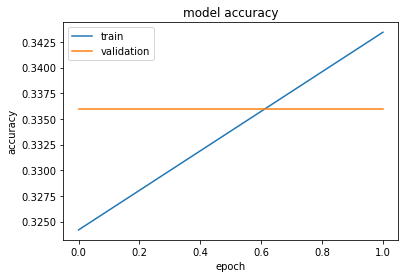

In [9]:
# training NN

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)


# Opening the files about data
Xtrain = pickle.load(open("Xtrain.pickle", "rb"))
ytrain = pickle.load(open("ytrain.pickle", "rb"))

testX = pickle.load(open("Xtest.pickle", "rb"))
testY = pickle.load(open("ytest.pickle", "rb"))

# normalizing data (a pixel goes from 0 to 255)
Xtrain = Xtrain/255.0
print("done")


#------------THIS IS THE NEURAL NETWORK
# Building the model
model = Sequential()
# 3 convolutional layers
model.add(Conv2D(16, (3, 3), input_shape = Xtrain.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))


#model.add(Dropout(0.25))

# 2 hidden layers
model.add(Flatten(input_shape = Xtrain.shape[1:]))
#model.add(Flatten())

model.add(Dense(32))
model.add(Activation("relu"))

#model.add(Dense(64))
#model.add(Activation("relu"))


# The output layer with 3 neurons, for 13 classes
model.add(Dense(3))
model.add(Activation("softmax"))


# Compiling the model using some basic parameters
model.compile(loss="sparse_categorical_crossentropy",
				optimizer="adam",
				metrics=["accuracy"])


xar=np.array(Xtrain)
yar=np.array(ytrain)

testX=np.array(testX)
testY=np.array(testY)


#---------TRAINING DATA GENERATOR (AUGMENTATION)

#train_datagen = ImageDataGenerator(brightness_range=[0.8,1.2],vertical_flip=True)
train_datagen = ImageDataGenerator(vertical_flip=True)
#print(yar)
# Training the model, with 40 iterations
# validation_split corresponds to the percentage of images used for the validation phase compared to all the images


model.summary()


#--------ACTUALLY TRAINING THE NETWORK
# history = model.fit(train_datagen.flow(Xtrain, ytrain, batch_size = 32),
#  validation_data = train_datagen.flow(testX, testY, batch_size=32), steps_per_epoch = len(Xtrain) // 32,
# # epochs =100)
#  epochs = 100,callbacks=[callback])

history = model.fit(xar, yar, batch_size=32,  epochs=2, validation_split=0.3)

model_json = model.to_json()
with open("innolabscrews.json", "w") as json_file :
	json_file.write(model_json)

model.save_weights("innolabscrews.h5")
print("Saved model to disk")

model.save('innolabscrews.model')

%matplotlib inline

# Printing a graph showing the accuracy changes during the training phase
print(history.history.keys())
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# Live detection

In [21]:
#Load Model

basemodel = tf.keras.models.load_model("base_ident.h5", compile=False)
screwmodel = tf.keras.models.load_model("screw_ident.h5", compile=False)
domenutmodel = tf.keras.models.load_model("domenut_ident.h5", compile=False)

print("ML model loaded")

ML model loaded


In [39]:
#live detection

BASECATEGORIES = ["unterlegscheibe","mutter","schraube","hutmutter"]
SCREWCATEGORIES = ["zylinderschr.","senkkopfschr.","sechskantschr.","gewinde"]
DOMENUTCATEGORIES = ["hutmutter_seite","hutmutter_oben"]
#CATEGORIES = ["washer","nut","zylinder","hex"]


zylinderschraube = np.asarray(pd.read_excel('zylinderschraube.xlsx'))
mutter = pd.read_excel('mutter.xlsx')
sechskantschraube = np.asarray(pd.read_excel('sechskantschraube.xlsx'))
unterlegscheibe = pd.read_excel('unterlegscheibe.xlsx')
senkschraube = np.asarray(pd.read_excel('senkschraube.xlsx'))


dimensions=3
IMG_SIZE = 224
width=35
camera=1
padding=10



videoCaptureObject = cv2.VideoCapture(camera)
change_res(1920, 1080)


active=True



#-----------Program loop

loadsettings()

createwindow()

while(active==True):    
    ret,frame = videoCaptureObject.read()

    image = frame
    imagefinal = image
    orig = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # perform edge detection, then perform a dilation + erosion to
    # close gaps in between object edges
    gettrackbars()
    gray = cv2.GaussianBlur(gray, (blur, blur), 0)
    edged = cv2.Canny(gray, mincanny, maxcanny)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)


    # find contours in the edge map
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if(len(cnts)>=1):

        # sort the contours from left-to-right and initialize the
        # 'pixels per metric' calibration variable
        (cnts, _) = contours.sort_contours(cnts)
                            

        # loop over the contours individually
        for c in cnts:

            # if the contour is not sufficiently large, ignore it
            if cv2.contourArea(c) < 100:
                continue

            # compute the rotated bounding box of the contour

            box = cv2.minAreaRect(c)
            box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
            box = np.array(box, dtype="int")
            # order the points in the contour such that they appear
            # in top-left, top-right, bottom-right, and bottom-left
            # order, then draw the outline of the rotated bounding
            # box
            box = perspective.order_points(box)
            
            #check that object is fully in the image

            coord=np.asarray(box)
            (h, w) = orig.shape[:2]
            if checkboundry(coord,h,w)==False:
                continue
                 
                   
            #-------Extract padded image for ML Analysis
            coordml=coord.copy()
            coordml[0,0]=coordml[0,0]-padding
            coordml[0,1]=coordml[0,1]-padding
            coordml[1,0]=coordml[1,0]+padding
            coordml[1,1]=coordml[1,1]-padding
            coordml[2,0]=coordml[2,0]+padding
            coordml[2,1]=coordml[2,1]+padding
            coordml[3,0]=coordml[3,0]-padding
            coordml[3,1]=coordml[3,1]+padding

#            predimage = crop_coord(imagefinal,coordml)

            predimage = crop_coord(image,coordml)
            
            washerimage=predimage.copy()

            #------NN Detection--------
            #----OLD
            
            
#             predimage = cv2.resize(predimage, (IMG_SIZE, IMG_SIZE))
#             predimage = predimage.reshape(IMG_SIZE, IMG_SIZE, dimensions)

#             prediction = model.predict(np.array([predimage]))

            #----NEW
            preddata = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
            #resize the image to a 224x224 with the same strategy as in TM2:
            #resizing the image to be at least 224x224 and then cropping from the center
            size = (224, 224)
            predimage = ImageOps.fit(Image.fromarray(predimage), size, Image.ANTIALIAS)

            #turn the image into a numpy array
            predimage_array = np.asarray(predimage)

            # Normalize the image
            normalized_predimage_array = (predimage_array.astype(np.float32) / 127.0) - 1
            # Load the image into the array
            preddata[0] = normalized_predimage_array
            prediction = basemodel.predict(preddata)
            prediction = list(prediction[0])
            prediction= BASECATEGORIES[prediction.index(max(prediction))]
            

                
            
            #--------------Draw outlines and information on the image
            cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
            # loop over the original points and draw them
            for (x, y) in box:
                cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)


            # unpack the ordered bounding box, then compute the midpoint
            # between the top-left and top-right coordinates, followed by
            # the midpoint between bottom-left and bottom-right coordinates
            (tl, tr, br, bl) = box
            (tltrX, tltrY) = midpoint(tl, tr)
            (blbrX, blbrY) = midpoint(bl, br)
            # compute the midpoint between the top-left and top-right points,
            # followed by the midpoint between the top-righ and bottom-right
            (tlblX, tlblY) = midpoint(tl, bl)
            (trbrX, trbrY) = midpoint(tr, br)


            # compute the Euclidean distance between the midpoints
            dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
            dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
            # if the pixels per metric has not been initialized, then
            # compute it as the ratio of pixels to supplied metric
            # (in this case, inches)age

            # compute the size of the object
            dimA = dA / pixelsPerMetric
            dimB = dB / pixelsPerMetric

            # draw the object sizes on the image
            cv2.putText(orig, "{:.1f}mm".format(dimA),
                (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
                0.55, (0, 0, 0), 2)
            cv2.putText(orig, "{:.1f}mm".format(dimB),
                (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
                0.55, (0, 0, 0), 2)
            
            
                        
            #-----------Split into subgroups
            
            #----------Screws

            if prediction=="schraube":
                img1,img2=getscrewhead(washerimage)
                
                
                preddata1 = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
                size = (224, 224)
                predimage1 = ImageOps.fit(Image.fromarray(img1), size, Image.ANTIALIAS)

                #turn the image into a numpy array
                predimage1_array = np.asarray(predimage1)

                # Normalize the image
                normalized_predimage1_array = (predimage1_array.astype(np.float32) / 127.0) - 1
                # Load the image into the array
                preddata1[0] = normalized_predimage1_array
                
                
                prediction1=screwmodel.predict(preddata1)
                prediction1 = list(prediction1[0])
                prediction1= SCREWCATEGORIES[prediction1.index(max(prediction1))]
                
                
                if prediction1=="gewinde":
                    size = (224, 224)
                    predimage1 = ImageOps.fit(Image.fromarray(img2), size, Image.ANTIALIAS)

                    #turn the image into a numpy array
                    predimage1_array = np.asarray(predimage1)

                    # Normalize the image
                    normalized_predimage1_array = (predimage1_array.astype(np.float32) / 127.0) - 1
                    # Load the image into the array
                    preddata1[0] = normalized_predimage1_array


                    prediction1=screwmodel.predict(preddata1)
                    prediction1 = list(prediction1[0])
                    prediction1= SCREWCATEGORIES[prediction1.index(max(prediction1))]

                partname=compare(prediction1,dimA,dimB)
                prediction=prediction1
                
            
            #-------------Washer
            
            elif(prediction=="unterlegscheibe"):
                dimension1=0
                dimension2=0
                edged2 = cv2.Canny(washerimage, mincanny, maxcanny)
                edged2 = cv2.dilate(edged2, None, iterations=1)
                edged2 = cv2.erode(edged2, None, iterations=1)
                cntswasher = cv2.findContours(edged2.copy(), cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
                cntswasher = imutils.grab_contours(cntswasher)
                
                for j in cntswasher:
                    if cv2.contourArea(j) < 100:
                        continue
                    box2 = cv2.minAreaRect(j)
                    box2 = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box2)
                    box2 = np.array(box2, dtype="int")
                    box2 = perspective.order_points(box2)
                    (tl2, tr2, br2, bl2) = box2
                    (tltrX2, tltrY2) = midpoint(tl2, tr2)
                    (blbrX2, blbrY2) = midpoint(bl2, br2)
                    (tlblX2, tlblY2) = midpoint(tl2, bl2)
                    (trbrX2, trbrY2) = midpoint(tr2, br2)
                    dA2 = dist.euclidean((tltrX2, tltrY2), (blbrX2, blbrY2))
                    dB2 = dist.euclidean((tlblX2, tlblY2), (trbrX2, trbrY2))
                    dimA2 = dA2 / pixelsPerMetric
                    dimB2 = dB2 / pixelsPerMetric
                    #print(dimA2)
                    #print(dimB2)
                    if(((dimA2+dimB2)/2)>dimension1):
                        dimension1=((dimA2+dimB2)/2)
                    elif(((dimA2+dimB2)/2)>dimension2):
                        dimension2=((dimA2+dimB2)/2)
                partname=compare("unterlegscheibe",dimension1,dimension2)
                        
                        
            #----------Domenuts
            
            elif prediction=="hutmutter":
                prediction=domenutmodel.predict(preddata)
                prediction = list(prediction[0])
                prediction= DOMENUTCATEGORIES[prediction.index(max(prediction))]
                if prediction=="hutmutter_oben":
                    partname=compare("mutter",dimA,dimB)
                else:
                    partname=compare("dome_side",dimA,dimB)
                    
            else:
                partname=compare(prediction,dimA,dimB)
                

            
            cv2.putText(orig,partname ,
                (int(trbrX + 10), int(trbrY+20)), cv2.FONT_HERSHEY_SIMPLEX,
                0.55, (0, 0, 0), 2)
            
            cv2.putText(orig,prediction,
                (int(trbrX + 10), int(trbrY+35)), cv2.FONT_HERSHEY_SIMPLEX,0.55, (0, 0, 0), 2)


    (h, w) = orig.shape[:2]
    cv2.rectangle(orig, (safetyzonex,safetyzoney), (w-safetyzonex,h-safetyzoney), (0, 0, 255) , 2)
    cv2.imshow('Capturing Video',orig)
    cv2.imshow('contour',edged)                        

    if(cv2.waitKey(1) & 0xFF == ord('q')):
        videoCaptureObject.release()
        cv2.destroyAllWindows()
        active=False
    
print("exit")

exit


# test stuff

In [9]:
type(predimage[0,0,0])

numpy.uint8

In [16]:
import tensorflow.keras
from PIL import Image, ImageOps
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)
CATEGORIES = ["washer","nut","zylinder","hex"]

# Load the model

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1.
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image
image = Image.open('test20.jpg')

#resize the image to a 224x224 with the same strategy as in TM2:
#resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size, Image.ANTIALIAS)

#turn the image into a numpy array
image_array = np.asarray(image)

# display the resized image
#image.show()

# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1

# Load the image into the array
data[0] = normalized_image_array

# run the inference
prediction = model.predict(data)
prediction = list(prediction[0])
print(CATEGORIES[prediction.index(max(prediction))])
print(prediction)

washer
[0.98790723, 0.008936687, 9.253132e-05, 0.003063515]


In [20]:
#resize all images in one folder

import PIL
import os
import os.path
from PIL import Image

f = r"C:/Users/maxim/Documents/Python/data/Traingoogle/senkkopf"
for file in os.listdir(f):
    f_img = f+"/"+file
    img = Image.open(f_img)
    img = img.resize((256,256))
    img.save(f_img)

In [10]:
def getscrewhead(screwimg):
    
    img = Image.fromarray(screwimg)
    
    
  
    # Size of the image in pixels (size of orginal image) 
    # (This is not mandatory) 
    width, height = img.size 


    # Cropped image of above dimension 
    # (It will not change orginal image) 
    image1 = img.crop((0, 0, width, width*0.6))
    image2 = img.crop((0, height-(width*0.6), width, height))
    return(image1,image2)



  
# Opens a image in RGB mode 
im = cv2.imread("test.jpg") 
  
im1,im2=getscrewhead(im)
im1.show() 
im2.show()